# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the azdias dataset
azdias = pd.read_csv("./data/Udacity_AZDIAS_052018.csv", sep=";")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Part 1: Clean Azdias dataset

In [3]:
# view azdias dataset
azdias.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   NaN                  NaN  ...   
1          NaN          NaN                  21.0                 11.0  ...   
2          NaN          NaN                  17.0                 10.0  ...   
3          NaN          NaN                  13.0                  1.0  ...   
4          NaN          NaN                  14.0                  3.0  ...   

   VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0  NaN       NaN         NaN      NaN             NaN             NaN   
1  4.0       8.0        11.0     10.0             3.0             9.0   
2  2.0       9.0         9.0      6.0             3.0             9.0   
3  0.0       7.0        10.0     11.0             NaN             9.0   
4  2.0       3.0         5.0      4.0             2.0             9.0   

   WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0       NaN        3         1                    2  
1       4.0        5         2                    1  
2       2.0        5         2                    3  
3       7.0        3         2                    4  
4       3.0        4         1                    3  

[5 rows x 366 columns]

In [4]:
print("There are {} rows and {} columns in the AZDIAS dataset".format(azdias.shape[0], azdias.shape[1]))

There are 891221 rows and 366 columns in the AZDIAS dataset


In [5]:
# get some basic info from data
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [6]:
# print dtypes of each column
azdias.dtypes

LNR                       int64
AGER_TYP                  int64
AKT_DAT_KL              float64
ALTER_HH                float64
ALTER_KIND1             float64
                         ...   
WOHNDAUER_2008          float64
WOHNLAGE                float64
ZABEOTYP                  int64
ANREDE_KZ                 int64
ALTERSKATEGORIE_GROB      int64
Length: 366, dtype: object

In [7]:
# get a copy of azdias
azdias_df = azdias.copy()

In [8]:
# pre-encoding unknowns properly, get columns with percentage of na greater than or equal to 30%
azdias_df.columns[azdias_df.isna().mean() >= 0.30]

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

In [9]:
# pre-encoding unknowns properly, get rows with the percentage of na greater than or equal to 30%
azdias_df.index[azdias_df.isna().mean(axis=1) >= 0.30]

Int64Index([     0,     11,     14,     15,     17,     20,     23,     24,
                26,     30,
            ...
            891154, 891159, 891164, 891170, 891171, 891172, 891173, 891175,
            891185, 891187],
           dtype='int64', length=105805)

In [10]:
# replace XX, -1, and X with np.nan in azdias_df
azdias_df = azdias_df.replace(["XX", "X", -1], np.nan)

In [11]:
# There are some unknowns encoded as 0, 10 and 9, using the documentation, get the columns
unknown_10 = ["D19_BANKEN_DATUM", "D19_BANKEN_OFFLINE_DATUM", "D19_BANKEN_ONLINE_DATUM", "D19_GESAMT_DATUM", 
              "D19_GESAMT_ONLINE_DATUM", "D19_TELKO_DATUM", "D19_TELKO_OFFLINE_DATUM", "D19_TELKO_ONLINE_DATUM", 
              "D19_VERSAND_DATUM", "D19_VERSAND_OFFLINE_DATUM", "D19_VERSAND_ONLINE_DATUM"]

unknown_9 = ["ALTERSKATEGORIE_GROB", "KBA05_ALTER1", "KBA05_ALTER2", "KBA05_ALTER3", "KBA05_ALTER4", "KBA05_ANHANG", 
             "KBA05_AUTOQUOT", "KBA05_CCM1", "KBA05_CCM2", "KBA05_CCM3", "KBA05_CCM4", "KBA05_DIESEL", "KBA05_FRAU", 
             "KBA05_HERST1", "KBA05_HERST2", "KBA05_HERST3", "KBA05_HERST4", "KBA05_HERST5", "KBA05_HERSTTEMP", 
             "KBA05_KRSAQUOT", "KBA05_KRSHERST1", "KBA05_KRSHERST2", "KBA05_KRSHERST3", "KBA05_KRSKLEIN", "KBA05_KRSOBER", 
             "KBA05_KRSVAN", "KBA05_KRSZUL", "KBA05_KW1", "KBA05_KW2", "KBA05_KW3", "KBA05_MAXAH", "KBA05_MAXBJ", 
             "KBA05_MAXHERST", "KBA05_MAXSEG", "KBA05_MAXVORB", "KBA05_MOD1", "KBA05_MOD2", "KBA05_MOD3", "KBA05_MOD4", 
             "KBA05_MOD8", "KBA05_MODTEMP", "KBA05_MOTOR", "KBA05_MOTRAD", "KBA05_SEG1", "KBA05_SEG10", "KBA05_SEG2", 
             "KBA05_SEG3", "KBA05_SEG4", "KBA05_SEG5", "KBA05_SEG6", "KBA05_SEG7", "KBA05_SEG8", "KBA05_SEG9", "KBA05_VORB0", 
             "KBA05_VORB1", "KBA05_VORB2", "KBA05_ZUL1", "KBA05_ZUL2", "KBA05_ZUL3", "KBA05_ZUL4", "RELAT_AB", "SEMIO_DOM", 
             "SEMIO_ERL", "SEMIO_FAM", "SEMIO_KAEM", "SEMIO_KRIT", "SEMIO_KULT", "SEMIO_LUST", "SEMIO_MAT", "SEMIO_PFLICHT", 
             "SEMIO_RAT", "SEMIO_REL", "SEMIO_SOZ", "SEMIO_TRADV", "SEMIO_VERT", "ZABEOTYP"]

unknown_0 = ["AGER_TYP", "ALTERSKATEGORIE_GROB", "ALTER_HH", "ANREDE_KZ", "CJT_GESAMTTYP", "D19_BANKEN_ANZ_12", 
             "D19_BANKEN_ANZ_24", "D19_BANKEN_DIREKT", "D19_BANKEN_GROSS", "D19_BANKEN_LOKAL", "D19_BANKEN_GROSS", 
             "D19_BANKEN_ONLINE_QUOTE_12", "D19_BANKEN_REST", "D19_BEKLEIDUNG_GEH", "D19_BEKLEIDUNG_REST", "D19_BILDUNG", 
             "D19_BIO_OEKO", "D19_BUCH_CD", "D19_DIGIT_SERV", "D19_DROGERIEARTIKEL", "D19_ENERGIE", "D19_FREIZEIT", 
             "D19_GARTEN", "D19_GESAMT_ANZ_12", "D19_GESAMT_ANZ_24", "D19_GESAMT_ONLINE_QUOTE_12", "D19_HANDWERK", 
             "D19_HAUS_DEKO", "D19_KINDERARTIKEL", "D19_KOSMETIK", "D19_LEBENSMITTEL", "D19_LOTTO", "D19_NAHRUNGSERGAENZUNG", 
             "D19_RATGEBER", "D19_REISEN", "D19_SAMMELARTIKEL", "D19_SCHUHE", "D19_SONSTIGE", "D19_TECHNIK", "D19_TELKO_ANZ_12",
             "D19_TELKO_ANZ_24", "D19_TELKO_MOBILE", "D19_TELKO_REST", "D19_TIERARTIKEL", "D19_VERSAND_ANZ_12", 
             "D19_VERSAND_ANZ_24", "D19_VERSAND_ONLINE_QUOTE_12", "D19_VERSAND_REST", "D19_VERSICHERUNGEN", "D19_VERSI_ANZ_12", 
             "D19_VERSI_ANZ_24", "D19_VOLLSORTIMENT", "D19_WEIN_FEINKOST", "GEBAEUDETYP", "HH_EINKOMMEN_SCORE", "KBA05_BAUMAX", 
             "KBA05_GBZ", "KKK", "NATIONALITAET_KZ", "PRAEGENDE_JUGENDJAHRE", "REGIOTYP", "RETOURTYP_BK_S", "TITEL_KZ", 
             "WOHNDAUER_2008", "W_KEIT_KIND_HH", "MIN_GEBAEUDEJAHR", "GEBURTSJAHR", "EINGEZOGENAM_HH_JAHR"]

In [12]:
# replace unknowns
unknowns = [[unknown_10, 10], [unknown_9, 9], [unknown_0, 0]]
for unknown in unknowns:
    for col in unknown[0]:
        azdias_df[col] = azdias_df[col].replace(unknown[1], np.nan)
    print("\nDone replacing all {}'s with NANs in applicable columns".format(unknown[1]))


Done replacing all 10's with NANs in applicable columns

Done replacing all 9's with NANs in applicable columns

Done replacing all 0's with NANs in applicable columns


In [13]:
# post-encoding unknowns properly, get columns with percentage of na greater than or equal to 30%
azdias_df.columns[azdias_df.isna().mean() >= 0.30]

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK',
       'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19

In [14]:
# post-encoding unknowns, get rows with percentage of na greater than or equal to 30%
azdias_df.index[azdias_df.isna().mean(axis=1) >= 0.30]

Int64Index([     0,     11,     13,     14,     15,     17,     20,     23,
                24,     26,
            ...
            891164, 891169, 891170, 891171, 891172, 891173, 891175, 891185,
            891187, 891203],
           dtype='int64', length=141931)

In [15]:
# rows with more than 30% na
azdias_row_na = azdias_df[azdias_df.isna().mean(axis=1) >= 0.30]

In [16]:
# rows with less than 30% na
azdias_df = azdias_df[azdias_df.isna().mean(axis=1) < 0.30]

In [17]:
# plot justification for row drop
# select any 5 columns to show an histogram of
column_plot = ["ALTERSKATEGORIE_GROB", "ANREDE_KZ", "NATIONALITAET_KZ", "ZABEOTYP", "SEMIO_SOZ"]
df_plot = [azdias_row_na, azdias_df]
df_label = ["azdias_na", "azdias"]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


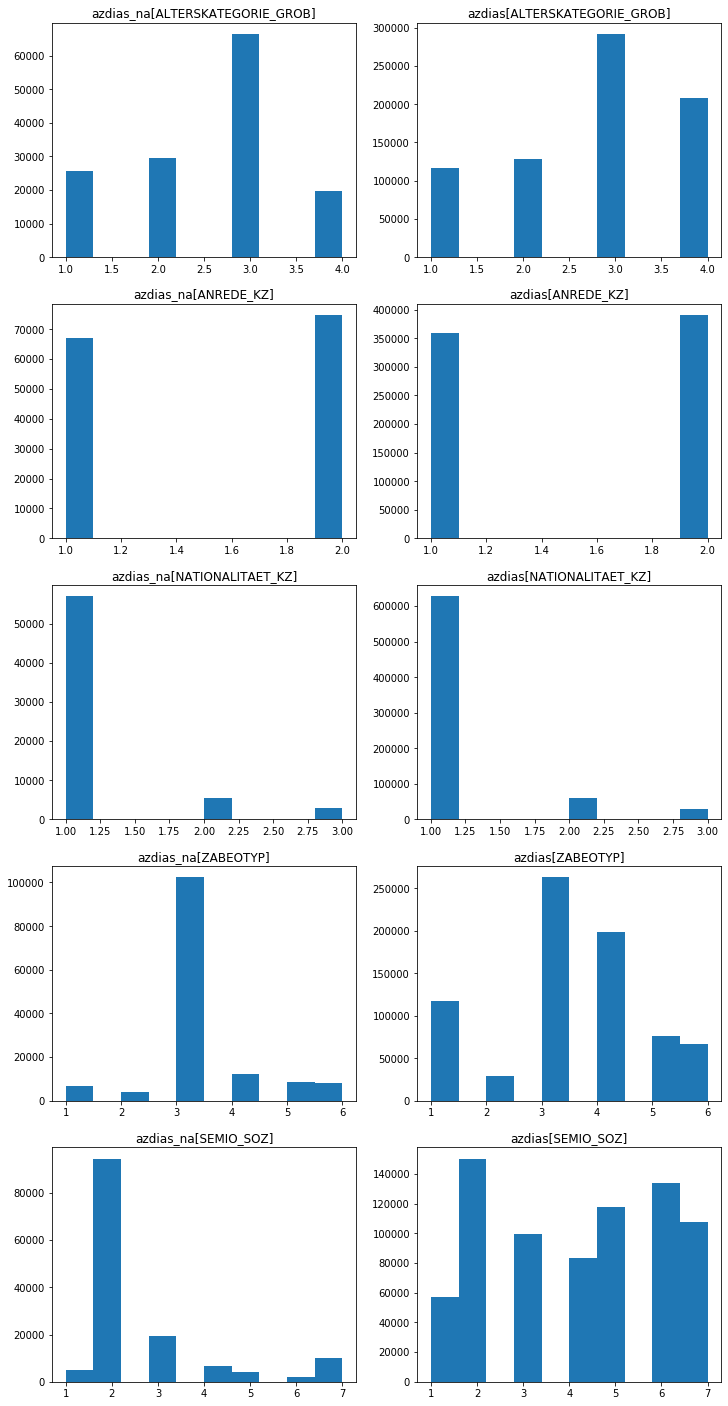

In [18]:
# plot distribution
# plot any 5 columns and compare distribution
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 25))
for i, col in enumerate(column_plot):
    for j, df in enumerate(df_plot):
        axes[i, j].hist(df[col])
        axes[i, j].set_title("{}[{}]".format(df_label[j], column_plot[i]))
        
plt.tight_layout
plt.show();

In [19]:
# get dataset shape
print("There are now {} rows and {} columns left in the AZDIAS dataset after row drop".format(azdias_df.shape[0], 
                                                                                              azdias_df.shape[1]))

There are now 749290 rows and 366 columns left in the AZDIAS dataset after row drop


In [20]:
# columns with more than 30% na
azdias_col_na = azdias_df[azdias_df.columns[azdias_df.isna().mean() >= 0.30]]
azdias_col_na.columns

Index(['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
       'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT',
       'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24',
       'D19_GESAMT_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_MOBIL

In [21]:
# keep columns with less than 30% na
azdias_df = azdias_df[azdias_df.columns[azdias_df.isna().mean() < 0.30]]

In [22]:
# get dataset shape
print("There are now {} rows and {} columns left in the AZDIAS dataset after column drop".format(azdias_df.shape[0], 
                                                                                                 azdias_df.shape[1]))

There are now 749290 rows and 298 columns left in the AZDIAS dataset after column drop


In [23]:
# find the column with dtype object
obj_col = azdias_df.select_dtypes(include="object").columns

In [24]:
# loop through each obj_col and print out the unique values
for col in obj_col:
    print("\n", col, " : ", azdias_df[col].unique())


 CAMEO_DEU_2015  :  ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '7A' '5D' '9E' '5C'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']

 CAMEO_DEUG_2015  :  [8.0 4.0 2.0 6.0 1.0 9.0 7.0 5.0 3.0 nan '3' '7' '2' '4' '9' '6' '8' '5'
 '1']

 CAMEO_INTL_2015  :  [51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 41.0 34.0 55.0 33.0 25.0 nan
 23.0 31.0 52.0 45.0 35.0 44.0 32.0 '24' '41' '12' '51' '44' '35' '23'
 '25' '14' '34' '52' '55' '31' '32' '22' '15' '13' '43' '45' '33' '54']

 D19_LETZTER_KAUF_BRANCHE  :  [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_SONSTIGE' 'D19_BANKEN_GROSS' 'D19_VOLLSORTIMENT'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE'

In [25]:
# split EINGEFUEGT_AM into year, month and day
date = pd.to_datetime(azdias_df["EINGEFUEGT_AM"])
azdias_df["EINGEFUEGT_AM_Year"] = date.dt.year.astype(int)
azdias_df["EINGEFUEGT_AM_Month"] = date.dt.month.astype(int)
azdias_df["EINGEFUEGT_AM_Day"] = date.dt.day.astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [26]:
# keep only the first digit of CAMEO_INTL_2015 as float
azdias_df["CAMEO_INTL_2015"] = azdias_df["CAMEO_INTL_2015"].astype(float) // 10

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
# encode OST_WEST_KZ
azdias_df["OST_WEST_KZ"] = azdias_df["OST_WEST_KZ"].map({"W": 0, "O": 1}, na_action="ignore")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
# drop CAMEO_DEU_2015 and CAMEO_DEUG_2015 as the same information is in CAMEO_INTL_2015
# drop LP_FAMILIE_FEIN as same information is contained in LP_FAMILIE_GROB
# drop LP_LEBENSPHASE_FEIN as same information is contained in LP_LEBENSPHASE_GROB
# drop LP_STATUS_FEIN as same information is contained in LP_STATUS_GROB
# drop EINGEFUEGT_AM as it has already been encoded
azdias_df.drop(["CAMEO_DEU_2015", "CAMEO_DEUG_2015", "EINGEFUEGT_AM", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN", 
                "LP_LEBENSPHASE_FEIN"], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
# perform some exploratory analysis later, so save a copy of df before adding dummy columns
azdias_df2 = azdias_df.copy()
azdias_df2.to_csv("./data/azdias_exploratory.csv", header=True, index=False)

In [30]:
# categorical columns to encode
cat_encode = ["ARBEIT", "D19_KONSUMTYP", "GFK_URLAUBERTYP", "HEALTH_TYP", "KBA05_MAXHERST", "LP_FAMILIE_GROB", "LP_STATUS_GROB", "LP_LEBENSPHASE_GROB", 
              "NATIONALITAET_KZ", "RETOURTYP_BK_S", "ZABEOTYP", "D19_LETZTER_KAUF_BRANCHE"]

In [31]:
# encode dummy columns
azdias_df = pd.get_dummies(data=azdias_df, columns=cat_encode)

In [32]:
# save clean data
azdias_df.to_csv("./data/azdias_cleaned.csv", header=True, index=False)

In [33]:
azdias_df.head()

LNR  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
1  910220         9.0       NaN                  21.0                 11.0   
2  910225         9.0      17.0                  17.0                 10.0   
3  910226         1.0      13.0                  13.0                  1.0   
4  910241         1.0      20.0                  14.0                  3.0   
5  910244         1.0      10.0                  10.0                  5.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
1           0.0         0.0           2.0                        12.0   
2           0.0         0.0           1.0                         7.0   
3           0.0         0.0           0.0                         2.0   
4           0.0         0.0           4.0                         3.0   
5           0.0         0.0           1.0                         2.0   

   ANZ_TITEL  ...  D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE  \
1        0.0  ...                                      0   
2        0.0  ...                                      0   
3        0.0  ...                                      0   
4        0.0  ...                                      0   
5        0.0  ...                                      0   

   D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK  \
1                                     0   
2                                     0   
3                                     0   
4                                     0   
5                                     0   

   D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE  \
1                                          0   
2                                          0   
3                                          0   
4                                          0   
5                                          0   

   D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST  \
1                                        0   
2                                        0   
3                                        0   
4                                        0   
5                                        0   

   D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL  \
1                                         0   
2                                         0   
3                                         0   
4                                         0   
5                                         0   

   D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT  \
1                                       0   
2                                       1   
3                                       1   
4                                       0   
5                                       0   

   D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST  \
1                                          0   
2                                          0   
3                                          0   
4                                          0   
5                                          0   

   D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN  \
1                                            0   
2                                            0   
3                                            0   
4                                            0   
5                                            0   

   D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT  \
1                                           0   
2                                           0   
3                                           0   
4                                           0   
5                                           0   

   D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST  
1                                           0  
2                                           0  
3                                           0  
4                                           0  
5                                           0  

[5 rows x 389 columns]

In [34]:
# function to clean data

def clean_dataframe(azd):
    
    """
    INPUT:
    azd - pandas dataframe to be cleaned
    
    OUTPUT:
    azd_df - cleaned pandas dataframe 
    
    Description:
    Return a pandas dataframe that has:
    - all unknowns converted to NaNs
    - dropped rows and columns with NaN above 30%
    - categorical columnns properly encoded, 
    - some similar columns dropped
    
    """
    print("Starting Dataframe cleaning ... ")
    
    # get a copy of azd
    azd_df = azd.copy()
    
    print("\nThere are {} rows and {} columns in this dataset".format(azd_df.shape[0], azd_df.shape[1]))

    # replace XX, -1, and X with np.nan in azd_df
    azd_df = azd_df.replace(["XX", "X", -1], np.nan)
    
    # There are some unknowns encoded as 0, 10 and 9
    unknown_10 = ["D19_BANKEN_DATUM", "D19_BANKEN_OFFLINE_DATUM", "D19_BANKEN_ONLINE_DATUM", "D19_GESAMT_DATUM", 
                  "D19_GESAMT_ONLINE_DATUM", "D19_TELKO_DATUM", "D19_TELKO_OFFLINE_DATUM", "D19_TELKO_ONLINE_DATUM", 
                  "D19_VERSAND_DATUM", "D19_VERSAND_OFFLINE_DATUM", "D19_VERSAND_ONLINE_DATUM"]

    unknown_9 = ["ALTERSKATEGORIE_GROB", "KBA05_ALTER1", "KBA05_ALTER2", "KBA05_ALTER3", "KBA05_ALTER4", "KBA05_ANHANG", 
                 "KBA05_AUTOQUOT", "KBA05_CCM1", "KBA05_CCM2", "KBA05_CCM3", "KBA05_CCM4", "KBA05_DIESEL", "KBA05_FRAU", 
                 "KBA05_HERST1", "KBA05_HERST2", "KBA05_HERST3", "KBA05_HERST4", "KBA05_HERST5", "KBA05_HERSTTEMP", 
                 "KBA05_KRSAQUOT", "KBA05_KRSHERST1", "KBA05_KRSHERST2", "KBA05_KRSHERST3", "KBA05_KRSKLEIN", "KBA05_KRSOBER", 
                 "KBA05_KRSVAN", "KBA05_KRSZUL", "KBA05_KW1", "KBA05_KW2", "KBA05_KW3", "KBA05_MAXAH", "KBA05_MAXBJ", 
                 "KBA05_MAXHERST", "KBA05_MAXSEG", "KBA05_MAXVORB", "KBA05_MOD1", "KBA05_MOD2", "KBA05_MOD3", "KBA05_MOD4", 
                 "KBA05_MOD8", "KBA05_MODTEMP", "KBA05_MOTOR", "KBA05_MOTRAD", "KBA05_SEG1", "KBA05_SEG10", "KBA05_SEG2", 
                 "KBA05_SEG3", "KBA05_SEG4", "KBA05_SEG5", "KBA05_SEG6", "KBA05_SEG7", "KBA05_SEG8", "KBA05_SEG9", "KBA05_VORB0",
                 "KBA05_VORB1", "KBA05_VORB2", "KBA05_ZUL1", "KBA05_ZUL2", "KBA05_ZUL3", "KBA05_ZUL4", "RELAT_AB", "SEMIO_DOM", 
                 "SEMIO_ERL", "SEMIO_FAM", "SEMIO_KAEM", "SEMIO_KRIT", "SEMIO_KULT", "SEMIO_LUST", "SEMIO_MAT", "SEMIO_PFLICHT", 
                 "SEMIO_RAT", "SEMIO_REL", "SEMIO_SOZ", "SEMIO_TRADV", "SEMIO_VERT", "ZABEOTYP"]

    unknown_0 = ["AGER_TYP", "ALTERSKATEGORIE_GROB", "ALTER_HH", "ANREDE_KZ", "CJT_GESAMTTYP", "D19_BANKEN_ANZ_12", 
                 "D19_BANKEN_ANZ_24", "D19_BANKEN_DIREKT", "D19_BANKEN_GROSS", "D19_BANKEN_LOKAL", "D19_BANKEN_GROSS", 
                 "D19_BANKEN_ONLINE_QUOTE_12", "D19_BANKEN_REST", "D19_BEKLEIDUNG_GEH", "D19_BEKLEIDUNG_REST", "D19_BILDUNG", 
                 "D19_BIO_OEKO", "D19_BUCH_CD", "D19_DIGIT_SERV", "D19_DROGERIEARTIKEL", "D19_ENERGIE", "D19_FREIZEIT", 
                 "D19_GARTEN", "D19_GESAMT_ANZ_12", "D19_GESAMT_ANZ_24", "D19_GESAMT_ONLINE_QUOTE_12", "D19_HANDWERK", 
                 "D19_HAUS_DEKO", "D19_KINDERARTIKEL", "D19_KOSMETIK", "D19_LEBENSMITTEL", "D19_LOTTO", "D19_NAHRUNGSERGAENZUNG", 
                 "D19_RATGEBER", "D19_REISEN", "D19_SAMMELARTIKEL", "D19_SCHUHE", "D19_SONSTIGE", "D19_TECHNIK", 
                 "D19_TELKO_ANZ_12", "D19_TELKO_ANZ_24", "D19_TELKO_MOBILE", "D19_TELKO_REST", "D19_TIERARTIKEL", 
                 "D19_VERSAND_ANZ_12", "D19_VERSAND_ANZ_24", "D19_VERSAND_ONLINE_QUOTE_12", "D19_VERSAND_REST", 
                 "D19_VERSICHERUNGEN", "D19_VERSI_ANZ_12", "D19_VERSI_ANZ_24", "D19_VOLLSORTIMENT", "D19_WEIN_FEINKOST", 
                 "GEBAEUDETYP", "HH_EINKOMMEN_SCORE", "KBA05_BAUMAX", "KBA05_GBZ", "KKK", "NATIONALITAET_KZ", 
                 "PRAEGENDE_JUGENDJAHRE", "REGIOTYP", "RETOURTYP_BK_S", "TITEL_KZ", "WOHNDAUER_2008", "W_KEIT_KIND_HH", 
                 "MIN_GEBAEUDEJAHR", "GEBURTSJAHR", "EINGEZOGENAM_HH_JAHR"]
    
    # replace unknowns
    unknowns = [[unknown_10, 10], [unknown_9, 9], [unknown_0, 0]]
    for unknown in unknowns:
        for col in unknown[0]:
            azd_df[col] = azd_df[col].replace(unknown[1], np.nan)
        print("\nDone replacing all {}'s with NANs in applicable columns".format(unknown[1]))
        
    # keep only rows with less than 30% na
    azd_df = azd_df[azd_df.isna().mean(axis=1) < 0.30]
    
    print("\nThere are now {} rows and {} columns left in this dataset after NaN row drop".format(azd_df.shape[0], 
                                                                                                 azd_df.shape[1]))
    
    # keep columns with only less than 30% na
    azd_column_na = ["AGER_TYP", "ALTER_KIND1", "ALTER_KIND2", "ALTER_KIND3", "ALTER_KIND4", "D19_BANKEN_ANZ_12",
                        "D19_BANKEN_ANZ_24", "D19_BANKEN_DATUM", "D19_BANKEN_DIREKT", "D19_BANKEN_GROSS", "D19_BANKEN_LOKAL", 
                        "D19_BANKEN_OFFLINE_DATUM", "D19_BANKEN_ONLINE_DATUM", "D19_BANKEN_ONLINE_QUOTE_12", "D19_BANKEN_REST", 
                        "D19_BEKLEIDUNG_GEH", "D19_BEKLEIDUNG_REST", "D19_BILDUNG", "D19_BIO_OEKO", "D19_BUCH_CD", 
                        "D19_DIGIT_SERV", "D19_DROGERIEARTIKEL", "D19_ENERGIE", "D19_FREIZEIT", "D19_GARTEN", 
                        "D19_GESAMT_ANZ_12", "D19_GESAMT_ANZ_24", "D19_GESAMT_DATUM", "D19_GESAMT_ONLINE_DATUM", 
                        "D19_GESAMT_ONLINE_QUOTE_12", "D19_HANDWERK", "D19_HAUS_DEKO", "D19_KINDERARTIKEL", "D19_KOSMETIK", 
                        "D19_LEBENSMITTEL", "D19_LOTTO", "D19_NAHRUNGSERGAENZUNG", "D19_RATGEBER", "D19_REISEN", 
                        "D19_SAMMELARTIKEL", "D19_SCHUHE", "D19_SONSTIGE", "D19_TECHNIK", "D19_TELKO_ANZ_12", 
                        "D19_TELKO_ANZ_24", "D19_TELKO_DATUM", "D19_TELKO_MOBILE", "D19_TELKO_OFFLINE_DATUM", 
                        "D19_TELKO_ONLINE_DATUM", "D19_TELKO_REST", "D19_TIERARTIKEL", "D19_VERSAND_ANZ_12", 
                        "D19_VERSAND_ANZ_24", "D19_VERSAND_DATUM", "D19_VERSAND_OFFLINE_DATUM", "D19_VERSAND_ONLINE_DATUM", 
                        "D19_VERSAND_ONLINE_QUOTE_12", "D19_VERSAND_REST", "D19_VERSI_ANZ_12", "D19_VERSI_ANZ_24",
                        "D19_VERSICHERUNGEN", "D19_VOLLSORTIMENT", "D19_WEIN_FEINKOST", "EXTSEL992", "GEBURTSJAHR",
                        "KBA05_BAUMAX", "KK_KUNDENTYP", "TITEL_KZ"]
    azd_df.drop(azd_column_na, axis=1, inplace=True)
    
    print("\nThere are now {} rows and {} columns left in this dataset after NaN column drop".format(azd_df.shape[0], 
                                                                                                 azd_df.shape[1]))
    
    # split EINGEFUEGT_AM into year, month and day
    date = pd.to_datetime(azd_df["EINGEFUEGT_AM"])
    azd_df["EINGEFUEGT_AM_Year"] = date.dt.year.astype(int)
    azd_df["EINGEFUEGT_AM_Month"] = date.dt.month.astype(int)
    azd_df["EINGEFUEGT_AM_Day"] = date.dt.day.astype(int)
    
    # keep only the first digit of CAMEO_INTL_2015 as float
    azd_df["CAMEO_INTL_2015"] = azd_df["CAMEO_INTL_2015"].astype(float) // 10
    
    # encode OST_WEST_KZ
    azd_df["OST_WEST_KZ"] = azd_df["OST_WEST_KZ"].map({"W": 0, "O": 1}, na_action="ignore")
    
    # drop CAMEO_DEU_2015 and CAMEO_DEUG_2015 as the same information is in CAMEO_INTL_2015
    # drop LP_FAMILIE_FEIN as same information is contained in LP_FAMILIE_GROB
    # drop LP_LEBENSPHASE_FEIN as same information is contained in LP_LEBENSPHASE_GROB
    # drop LP_STATUS_FEIN as same information is contained in LP_STATUS_GROB
    # drop EINGEFUEGT_AM as it has already been encoded
    azd_df.drop(["CAMEO_DEU_2015", "CAMEO_DEUG_2015", "EINGEFUEGT_AM", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN", 
                    "LP_LEBENSPHASE_FEIN"], axis=1, inplace=True)
    
    # categorical columns to encode
    cat_encode = ["ARBEIT", "D19_KONSUMTYP", "GFK_URLAUBERTYP", "HEALTH_TYP", "KBA05_MAXHERST", "LP_FAMILIE_GROB", 
                  "LP_STATUS_GROB", "LP_LEBENSPHASE_GROB", "NATIONALITAET_KZ", "RETOURTYP_BK_S", "ZABEOTYP", 
                  "D19_LETZTER_KAUF_BRANCHE"]
    
    # encode dummy columns
    azd_df = pd.get_dummies(data=azd_df, columns=cat_encode)
    
    print("\nDataframe has been completely cleaned")
    
    return azd_df

In [35]:
# use function to re-clean customer_segmentation datatframe so we can compare output is same
azdias_df3 = clean_dataframe(azdias)
azdias_df3.head()

Starting Dataframe cleaning ... 

There are 891221 rows and 366 columns in this dataset

Done replacing all 10's with NANs in applicable columns

Done replacing all 9's with NANs in applicable columns

Done replacing all 0's with NANs in applicable columns

There are now 749290 rows and 366 columns left in this dataset after NaN row drop

There are now 749290 rows and 298 columns left in this dataset after NaN column drop

Dataframe has been completely cleaned


LNR  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
1  910220         9.0       NaN                  21.0                 11.0   
2  910225         9.0      17.0                  17.0                 10.0   
3  910226         1.0      13.0                  13.0                  1.0   
4  910241         1.0      20.0                  14.0                  3.0   
5  910244         1.0      10.0                  10.0                  5.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
1           0.0         0.0           2.0                        12.0   
2           0.0         0.0           1.0                         7.0   
3           0.0         0.0           0.0                         2.0   
4           0.0         0.0           4.0                         3.0   
5           0.0         0.0           1.0                         2.0   

   ANZ_TITEL  ...  D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE  \
1        0.0  ...                                      0   
2        0.0  ...                                      0   
3        0.0  ...                                      0   
4        0.0  ...                                      0   
5        0.0  ...                                      0   

   D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK  \
1                                     0   
2                                     0   
3                                     0   
4                                     0   
5                                     0   

   D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE  \
1                                          0   
2                                          0   
3                                          0   
4                                          0   
5                                          0   

   D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST  \
1                                        0   
2                                        0   
3                                        0   
4                                        0   
5                                        0   

   D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL  \
1                                         0   
2                                         0   
3                                         0   
4                                         0   
5                                         0   

   D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT  \
1                                       0   
2                                       1   
3                                       1   
4                                       0   
5                                       0   

   D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST  \
1                                          0   
2                                          0   
3                                          0   
4                                          0   
5                                          0   

   D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN  \
1                                            0   
2                                            0   
3                                            0   
4                                            0   
5                                            0   

   D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT  \
1                                           0   
2                                           0   
3                                           0   
4                                           0   
5                                           0   

   D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST  
1                                           0  
2                                           0  
3                                           0  
4                                           0  
5                                           0  

[5 rows x 389 columns]

In [36]:
# load in the customer dataset
customer = pd.read_csv("./data/Udacity_CUSTOMERS_052018.csv", sep=";")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
# clean customer dataset
customer_df = clean_dataframe(customer)
customer_df.head()

Starting Dataframe cleaning ... 

There are 191652 rows and 369 columns in this dataset

Done replacing all 10's with NANs in applicable columns

Done replacing all 9's with NANs in applicable columns

Done replacing all 0's with NANs in applicable columns

There are now 136599 rows and 369 columns left in this dataset after NaN row drop

There are now 136599 rows and 301 columns left in this dataset after NaN column drop

Dataframe has been completely cleaned


LNR  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0    9626         1.0      10.0                  10.0                  1.0   
2  143872         1.0       6.0                   0.0                  1.0   
3  143873         1.0       8.0                   8.0                  0.0   
4  143874         1.0      20.0                  14.0                  7.0   
5  143888         1.0      11.0                  10.0                  1.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           0.0         0.0           2.0                         1.0   
2           0.0         0.0           1.0                         1.0   
3           NaN         0.0           0.0                         1.0   
4           0.0         0.0           4.0                         7.0   
5           0.0         0.0           2.0                         1.0   

   ANZ_TITEL  ...  D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE  \
0        0.0  ...                                      0   
2        0.0  ...                                      0   
3        0.0  ...                                      0   
4        0.0  ...                                      0   
5        0.0  ...                                      0   

   D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK  \
0                                     0   
2                                     0   
3                                     0   
4                                     0   
5                                     0   

   D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE  \
0                                          0   
2                                          0   
3                                          0   
4                                          0   
5                                          0   

   D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST  \
0                                        0   
2                                        0   
3                                        0   
4                                        0   
5                                        0   

   D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL  \
0                                         0   
2                                         0   
3                                         0   
4                                         0   
5                                         0   

   D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT  \
0                                       1   
2                                       1   
3                                       0   
4                                       0   
5                                       0   

   D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST  \
0                                          0   
2                                          0   
3                                          0   
4                                          0   
5                                          0   

   D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN  \
0                                            0   
2                                            0   
3                                            0   
4                                            0   
5                                            0   

   D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT  \
0                                           0   
2                                           0   
3                                           0   
4                                           0   
5                                           0   

   D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST  
0                                           0  
2                                           0  
3                                           0  
4                                           0  
5                                           0  

[5 rows x 392 columns]

In [38]:
# save clean dataset
customer_df.to_csv("./data/customer_cleaned.csv", header=True, index=False)